## Predicting Stock Prices

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf



### Downloading data

In [2]:
msft = yf.Ticker('MSFT')
msft_data = msft.history(period = 'max')

### Exploring data

In [3]:
msft_data.head(4)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.055898,0.064119,0.055898,0.061378,1031788800,0.0,0.0
1986-03-14,0.061378,0.064667,0.061378,0.063570,308160000,0.0,0.0
1986-03-17,0.063570,0.065215,0.063570,0.064667,133171200,0.0,0.0
1986-03-18,0.064667,0.065215,0.062474,0.063022,67766400,0.0,0.0


In [4]:
msft_data.tail(4)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-02-01,310.410004,310.630005,305.130005,308.760010,40950400,0.0,0.0
2022-02-02,309.630005,315.119995,308.880005,313.459991,36636000,0.0,0.0
2022-02-03,309.489990,311.230011,299.959991,301.250000,43730000,0.0,0.0
2022-02-04,300.209991,308.799988,299.970001,305.940002,35070300,0.0,0.0


<AxesSubplot:xlabel='Date'>

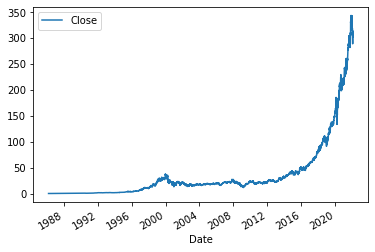

In [5]:
msft_data.plot(y ='Close', use_index = True)

### Stock prediction Problem

#### Defining Target

In [6]:
data = msft_data['Close']
data = data.rename('Actual Close')

In [11]:
data['target'] = msft_data.rolling(2).apply(lambda l: l.iloc[1]> l.iloc[0])['Close']

In [12]:
data = pd.DataFrame(data, columns =['Actual Close','target'])

In [13]:
data.head()

,Actual Close,target
Date,,
1986-03-13 00:00:00,0.0613783,NaN
1986-03-14 00:00:00,0.0635703,1.0
1986-03-17 00:00:00,0.0646669,1.0
1986-03-18 00:00:00,0.0630223,0.0
1986-03-19 00:00:00,0.0619263,0.0


In [32]:
data.drop(index=data.index[-1], axis =0, inplace =True)
data.tail(4)

,Actual Close,target
Date,,
2022-01-31 00:00:00,310.98,1.0
2022-02-01 00:00:00,308.76,0.0
2022-02-02 00:00:00,313.46,1.0
2022-02-03 00:00:00,301.25,0.0


#### Shifting data forward

In [33]:
msft_copy = msft_data.copy()
msft_pr = msft_copy.shift(1)

In [34]:
msft_pr.head(4)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14,0.055898,0.064119,0.055898,0.061378,1.031789e+09,0.0,0.0
1986-03-17,0.061378,0.064667,0.061378,0.063570,3.081600e+08,0.0,0.0
1986-03-18,0.063570,0.065215,0.063570,0.064667,1.331712e+08,0.0,0.0


In [35]:
predictors = ['Open','High','Low','Close','Volume']

In [36]:
data = data.join(msft_pr[predictors]).iloc[1:]

In [37]:
data.head(4)

,Actual Close,target,Open,High,Low,Close,Volume
Date,,,,,,,
1986-03-14,0.0635703,1.0,0.055898,0.064119,0.055898,0.061378,1.031789e+09
1986-03-17,0.0646669,1.0,0.061378,0.064667,0.061378,0.063570,3.081600e+08
1986-03-18,0.0630223,0.0,0.063570,0.065215,0.063570,0.064667,1.331712e+08
1986-03-19,0.0619263,0.0,0.064667,0.065215,0.062474,0.063022,6.776640e+07


#### Creating the model

In [38]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100,min_samples_split=200,random_state=1)

In [39]:
train = data.iloc[:-100]
test = data.iloc[-100:]

rf.fit(train[predictors],train['target'])

RandomForestClassifier(min_samples_split=200, random_state=1)

#### Evaluating model

In [43]:
from sklearn.metrics import precision_score

pred = rf.predict(test[predictors])
pred = pd.Series(pred, index = test.index)
precision_score(test['target'], pred)

0.625

<AxesSubplot:xlabel='Date'>

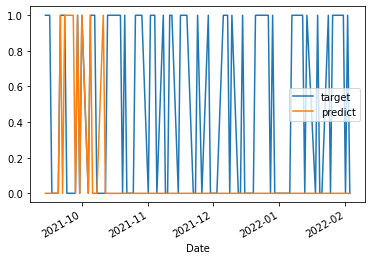

In [47]:
combined = pd.concat({'target':test['target'],'predict': pred}, axis = 1)
combined.plot()

#### Backtesting
we cannot do train test split because out data is kinda timeseries and we want to preserve the order. so we use backtesting with the selection of step. the smaller the step is, more accurate is the results. as well it gonna take more time to train the model. This approach helps us make predictions across the entire history of stock.

In [62]:
def backtest(data,model, predictors, start =1000, step=300):

    predictions =[]
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        model.fit(train[predictors], train['target'])
        
        pred = model.predict_proba(test[predictors])[:,1]
        pred = pd.Series(pred, index = test.index)

        pred[pred>0.6] = 1
        pred[pred<= .6] = 0

        combined = pd.concat({'target':test['target'],'predict': pred}, axis = 1)
        
        predictions.append(combined)
    return pd.concat(predictions)

In [64]:
predictions = backtest(data,rf,predictors)

In [66]:
predictions['predict'].value_counts()

0.0    7674
1.0     374
Name: predict, dtype: int64

In [67]:
precision_score(predictions['target'], predictions['predict'])

0.5213903743315508

#### Feature extrapolation to improve accuracy

In [68]:
#calculate some rolling means
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
yearly_mean = data.rolling(365).mean()
weekly_trend = data.shift(1).rolling(7).mean()['target']

In [73]:
#ratio of different indicators
data['weekly_mean'] = weekly_mean['Close']/data['Close']
data['Quarterly_mean'] = quarterly_mean['Close']/data['Close']
data['Annual_mean'] = yearly_mean['Close']/data['Close']

data['Annual_weekly_mean'] = data['Annual_mean']/data['weekly_mean']
data['Annual_quarterly_mean'] = data['Annual_mean']/data['Quarterly_mean']
data['Weekly_trend'] = weekly_trend

data['open_close_ratio'] = data['Open']/data['Close']
data['high_close_ratio'] = data['High']/data['Close']

In [75]:
ful_predictors = predictors+['weekly_mean','Quarterly_mean','Annual_mean','Annual_weekly_mean','Annual_quarterly_mean',
                            'Weekly_trend','open_close_ratio','high_close_ratio']

In [76]:
predictions = backtest(data.iloc[365:],rf,ful_predictors)

In [77]:
precision_score(predictions['target'], predictions['predict'])

0.5875486381322957

In [78]:
predictions['predict'].value_counts()

0.0    7426
1.0     257
Name: predict, dtype: int64

<AxesSubplot:xlabel='Date'>

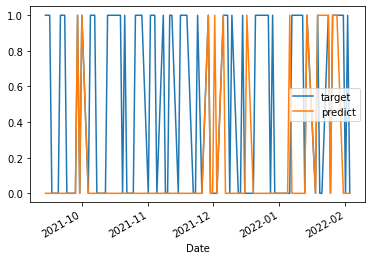

In [79]:
predictions.iloc[-100:].plot()